# Dfsu - Extract Track
Similar to the MIKE tool DataTrackExtractionFM.exe the Dfsu method extract_track() can be used to extract model data along a track (e.g. satellite altimetry track)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

import mikeio

# Load dfsu result file
The file contains surface elevation and wind speed model data. We wish to compare the model data with altimetry data 

In [2]:
track_file = '../tests/testdata/altimetry_NorthSea_20171027.csv'
data_file = '../tests/testdata/NorthSea_HD_and_windspeed.dfsu'

In [3]:
dfs = mikeio.open(data_file)
dfs

<mikeio.Dfsu2DH>
number of elements: 958
number of nodes: 570
projection: LONG/LAT
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)
time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00 (67 records)

# Load and visualize altimetry tracks 
The altimetry data is stored in a csv file. We plot the data on top of the dfsu mesh.

In [4]:
track = pd.read_csv(track_file, index_col=0, parse_dates=True)

In [5]:
track.head()

,lon,lat,surface_elevation,significant_wave_height,wind_speed
date,,,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449,0.426,6.100000
2017-10-26 04:37:54,8.221631,54.948459,1.1200,1.634,9.030000
2017-10-26 04:37:55,8.189390,55.008547,1.0882,1.717,9.370000
2017-10-26 04:37:56,8.157065,55.068627,1.0309,1.869,9.559999
2017-10-26 04:37:58,8.124656,55.128700,1.0369,1.939,9.980000


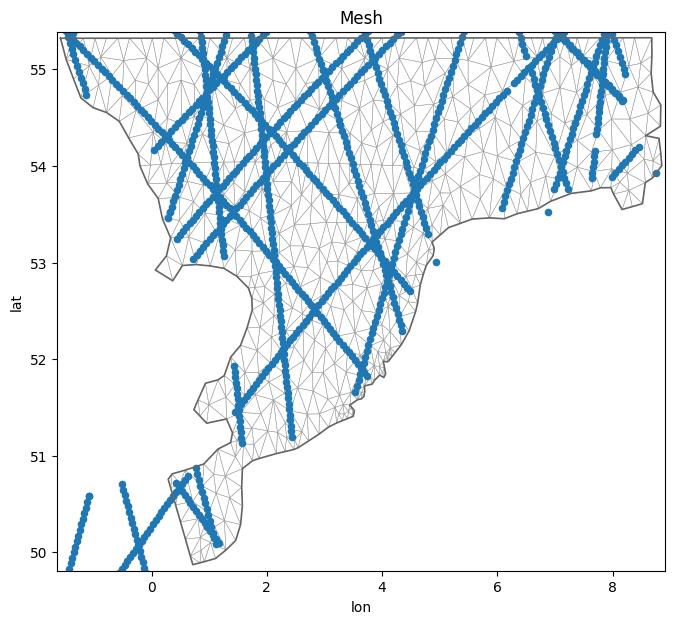

In [6]:
ax = dfs.geometry.plot.mesh(figsize=(8,7))
track.plot.scatter('lon','lat', ax=ax);

In [7]:
track_xy = track[['lon','lat']].values
print(f'Inside domain: {sum(dfs.geometry.contains(track_xy))} points of the track (total: {len(track_xy)})')

Inside domain: 922 points of the track (total: 1115)


# Extract track data from dfsu file
The extract_track() takes a track definition (time, longitude, latitude of each point) as either a dataframe, a csv-file, a dfs0 file or a mikeio.Dataset. 

In [8]:
e_track = dfs.extract_track(track_file)

In [9]:
# convert to dataframe and rename columns
df = e_track.to_dataframe()
df.columns = ['Longitude', 'Latitude', 'Model_surface_elevation', 'Model_wind_speed']

# Compare with the observed altimetry values

In [10]:
df['Obs_surface_elevation'] = track['surface_elevation']
df['Obs_wind_speed'] = track['wind_speed']
df.dropna(inplace=True)

In [11]:
resi = df.Model_wind_speed - df.Obs_wind_speed
bias = resi.median()
rmse = np.sqrt(np.mean(resi**2))
print(f'Wind speed: bias={bias:.2f}m/s, rmse={rmse:.2f}m/s')

Wind speed: bias=0.68m/s, rmse=2.05m/s


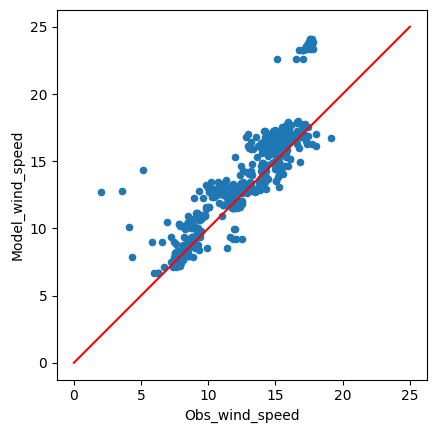

In [12]:
df.plot.scatter('Obs_wind_speed','Model_wind_speed')
plt.plot([0,25],[0,25], color='r')
plt.gca().set_aspect('equal')

In [13]:
resi = df.Model_surface_elevation - df.Obs_surface_elevation
bias = resi.median()
rmse = np.sqrt(np.mean(resi**2))
print(f'Surface elevation: bias={100*bias:.2f}cm, rmse={100*rmse:.2f}cm')

Surface elevation: bias=-6.34cm, rmse=11.50cm


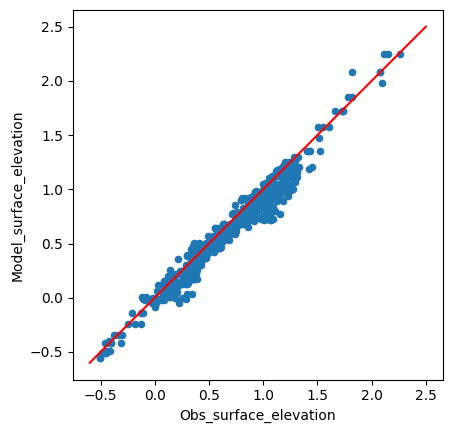

In [14]:
df.plot.scatter('Obs_surface_elevation','Model_surface_elevation')
plt.plot([-0.6,2.5],[-0.6,2.5], color='r')
plt.gca().set_aspect('equal')